In [1]:
import json
import os
import glob
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import itertools
import pickle
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_hub as hub

C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
root_path = "D:\\MinutesOfMeeting\\meeting-transcript-data\\parsed_data1"
file = "data_meeting_text_pdf_meetingtranscript566.txt"

In [3]:
def get_file_content(filename: str) -> json:
    with open(filename) as file_data:
        _data = json.load(file_data)

    return _data

In [4]:
def selected_topics(model, vectorizer, top_n=5):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [5]:
def classification_report(model_name, test, pred):    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [6]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [7]:
data = get_file_content(root_path + '\\' + file)

In [8]:
df = json_normalize(data,sep="_")

In [9]:
df.head()

,dialogue_id,page_number,sentence,speaker
0,0,4,"Thank you, everyone, and good morning again.",CHAIRMAN FRIEDMAN:
1,0,4,We have a couple of announcements.,CHAIRMAN FRIEDMAN:
2,0,4,"You have received those, and they're in your k...",CHAIRMAN FRIEDMAN:
3,0,5,Unless there are any questions or discussion a...,CHAIRMAN FRIEDMAN:
4,0,5,Is there anything on either of those?,CHAIRMAN FRIEDMAN:


In [10]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]
stopwords = list(set(stopwords) | set(custom_stop_words))

In [11]:
parser = spacy.load('en_core_web_sm', disable = ['ner', 'tagger'])

In [12]:
parser.max_length = 7000000
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [13]:
tqdm.pandas()
df["processed_text"] = df["sentence"].progress_apply(spacy_tokenizer)

100%|███████████████████████████████████████████████████████████████████████████████| 297/297 [00:02<00:00, 129.06it/s]


In [14]:
embed = hub.load("D:\\Embeddings\\universal-sentence-encoder_4")

In [15]:
def plot_clusters(vectors, pred, _type):
    
    tsne = TSNE(verbose=1, perplexity=100, random_state=42)
    embeddings = tsne.fit_transform(vectors.numpy())
    
    # sns settings
    sns.set(rc={'figure.figsize':(8, 8)})

    # colors
    palette = sns.hls_palette(4, l=.4, s=.9)

    # plot
    sns.scatterplot(embeddings[:,0], embeddings[:,1], hue=pred, legend='full', palette=palette)
    plt.title('t-SNE with ' + _type )
    plt.show()

In [16]:
def purity_of_clusters(k, label, embeddings, pred, title):
    vectorizers = []

    for ii in range(0, k):
        # Creating a vectorizer
        vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    vectorized_data = []
    vectorizers = []

    for ii in range(0, k):
        # Creating a vectorizer
        vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    vectorized_data = []
    for current_cluster, cvec in enumerate(vectorizers):
        try:
            vectorized_data.append(cvec.fit_transform(df.loc[df[label] == current_cluster, 'processed_text']))
        except Exception as e:
            print("Not enough instances in cluster: " + str(current_cluster))
            vectorized_data.append(None)
    lda_models = []
    for ii in range(0, k):
        # Latent Dirichlet Allocation Model
        lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online',verbose=False, random_state=42)
        lda_models.append(lda)

    clusters_lda_data = []
    for current_cluster, lda in enumerate(lda_models):
        # print("Current Cluster: " + str(current_cluster))

        if vectorized_data[current_cluster] != None:
            clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
    
    X_train, X_test, y_train, y_test = train_test_split(embeddings.numpy(), pred, test_size=0.4, random_state=42)

    sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
    # train SGD
    sgd_clf.fit(X_train, y_train)
    
    sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)
    # print out the classification report
    classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

    sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=5, n_jobs=-1)
    # print out the classification report
    classification_report("Stochastic Gradient Descent Report (Testing Set)", y_test, sgd_pred)

    sgd_cv_score = cross_val_score(sgd_clf, embeddings.numpy(), pred, cv=10)
    print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")
    
    class_names = [str(i+1) for i in range(0,k)]
    cm = confusion_matrix(y_test, sgd_pred)
    plot_confusion_matrix(cm, class_names, title = title)

In [17]:
k = 4

In [18]:
text = df['processed_text'].values
A = embed(text)

In [19]:
pca = PCA(n_components=0.95, random_state=42)
A_reduced= pca.fit_transform(A.numpy())
A_reduced.shape

(297, 132)

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42, n_jobs=-1)
y_pred_KM = kmeans.fit_predict(A_reduced)
df['cluster_KMeans'] = y_pred_KM

[t-SNE] Computing 296 nearest neighbors...
[t-SNE] Indexed 297 samples in 0.002s...
[t-SNE] Computed neighbors for 297 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 297 / 297
[t-SNE] Mean sigma: 0.448141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.271080
[t-SNE] KL divergence after 1000 iterations: 0.415531


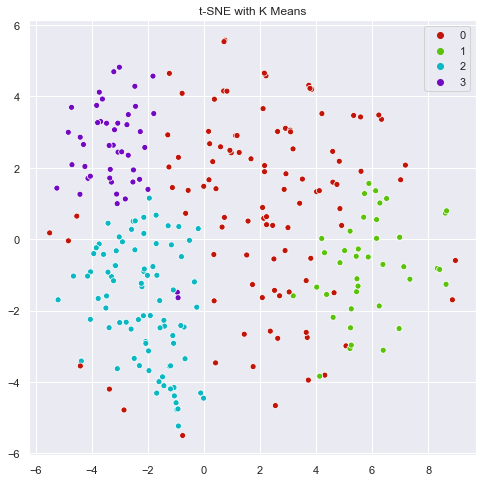

In [21]:
plot_clusters(A, y_pred_KM, "K Means")

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  91.011 %
     Precision:  91.615 %
        Recall:  90.978 %
      F1 score:  90.912 %
Stochastic Gradient Descent Report (Testing Set) :

Accuracy Score:  87.395 %
     Precision:  87.427 %
        Recall:  86.753 %
      F1 score:  86.864 %
Mean cv Score - SGD: 92.129 %


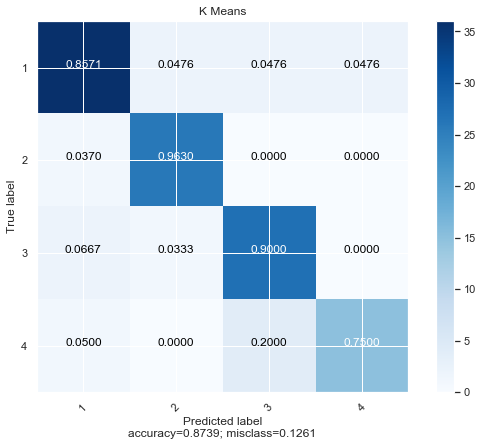

In [22]:
purity_of_clusters(k, "cluster_KMeans", A, y_pred_KM, "K Means")

In [23]:
gm = GaussianMixture(n_components=k)
gm = gm.fit(A_reduced)
y_pred_gm = gm.fit_predict(A_reduced)
df["cluster_GuassianMixture"] = y_pred_gm

[t-SNE] Computing 296 nearest neighbors...
[t-SNE] Indexed 297 samples in 0.000s...
[t-SNE] Computed neighbors for 297 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 297 / 297
[t-SNE] Mean sigma: 0.448141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.271080
[t-SNE] KL divergence after 1000 iterations: 0.415531


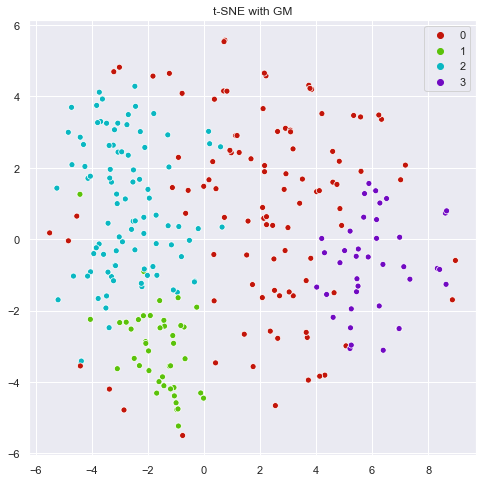

In [24]:
plot_clusters(A, y_pred_gm, "GM")

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  86.517 %
     Precision:  87.411 %
        Recall:  86.265 %
      F1 score:  86.391 %
Stochastic Gradient Descent Report (Testing Set) :

Accuracy Score:  89.076 %
     Precision:  91.381 %
        Recall:  88.141 %
      F1 score:  89.458 %
Mean cv Score - SGD: 90.315 %


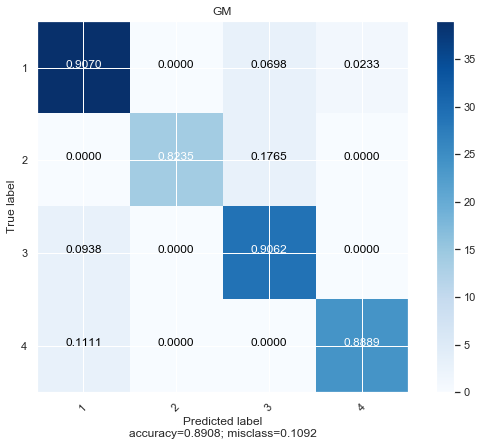

In [25]:
purity_of_clusters(k, "cluster_GuassianMixture", A, y_pred_gm, "GM")

In [26]:
birch = Birch(n_clusters=4, threshold=0.1)
y_pred_birch = birch.fit_predict(A_reduced)
df['cluster_birch'] = y_pred_birch

[t-SNE] Computing 296 nearest neighbors...
[t-SNE] Indexed 297 samples in 0.001s...
[t-SNE] Computed neighbors for 297 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 297 / 297
[t-SNE] Mean sigma: 0.448141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.271080
[t-SNE] KL divergence after 1000 iterations: 0.415531


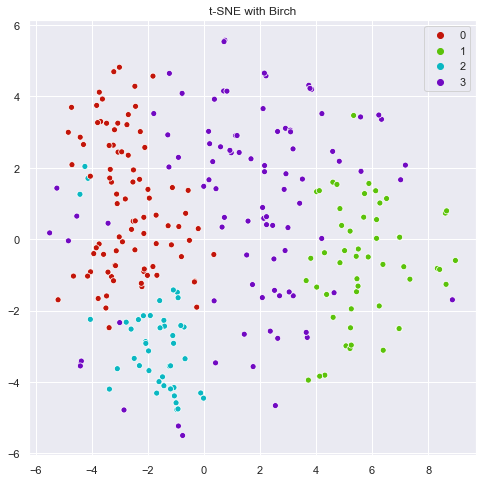

In [27]:
plot_clusters(A, y_pred_birch, "Birch")

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  84.831 %
     Precision:  87.090 %
        Recall:  85.427 %
      F1 score:  85.988 %
Stochastic Gradient Descent Report (Testing Set) :

Accuracy Score:  81.513 %
     Precision:  83.781 %
        Recall:  81.101 %
      F1 score:  82.144 %
Mean cv Score - SGD: 85.525 %


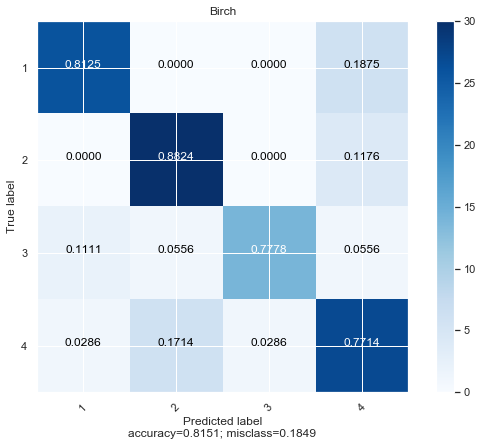

In [28]:
purity_of_clusters(k, "cluster_birch", A, y_pred_birch, "Birch")

In [29]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
y_pred_agglomerativeClustering = agglomerativeClustering.fit_predict(A_reduced)
df['cluster_agglomerativeClustering'] = y_pred_agglomerativeClustering

[t-SNE] Computing 296 nearest neighbors...
[t-SNE] Indexed 297 samples in 0.001s...
[t-SNE] Computed neighbors for 297 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 297 / 297
[t-SNE] Mean sigma: 0.448141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.271080
[t-SNE] KL divergence after 1000 iterations: 0.415531


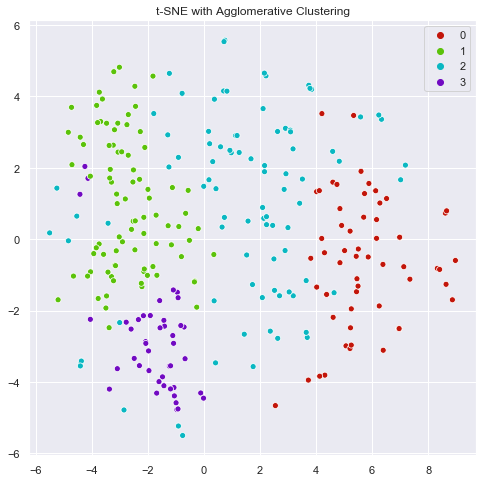

In [30]:
plot_clusters(A, y_pred_agglomerativeClustering, "Agglomerative Clustering")

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  77.528 %
     Precision:  77.102 %
        Recall:  79.633 %
      F1 score:  78.051 %
Stochastic Gradient Descent Report (Testing Set) :

Accuracy Score:  79.832 %
     Precision:  83.242 %
        Recall:  79.558 %
      F1 score:  81.002 %
Mean cv Score - SGD: 87.475 %


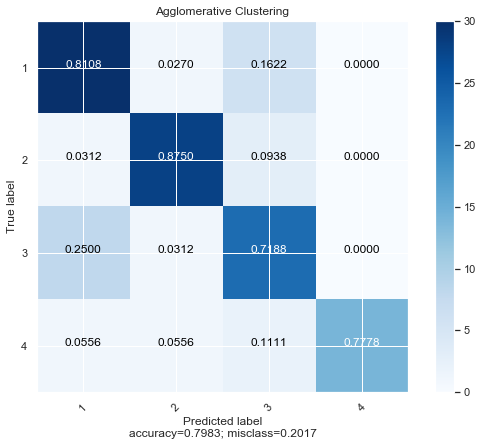

In [31]:
purity_of_clusters(k, "cluster_agglomerativeClustering", A, y_pred_agglomerativeClustering, "Agglomerative Clustering")